In [1]:
import azureml.core
import pandas as pd
import numpy as np
import logging

print(azureml.core.VERSION)

1.34.0


In [4]:
from azureml.core import Workspace, Experiment

ws = Workspace.from_config()

experiment_name = "cab_training_experiment"

experiment = Experiment(ws, experiment_name)

In [5]:
datastore = ws.get_default_datastore()
datastore.upload_files(files = ['./test.csv'],
                       target_path='dataset/', overwrite=True,
                       show_progress=True)

Uploading an estimated of 1 files
Uploading ./test.csv
Uploaded ./test.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_a3b9a23a5c6e410cb0ac17f33103d058

In [16]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = ''
resource_group = 'cabResourceGroup'
workspace_name = 'Cabalitics'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='cab_test_dataset')
df = dataset.to_pandas_dataframe()
df.head()

,pickups_in_1,pickups_in_2,pickups_in_3,pickups_in_4,pickups_in_5,pickups_in_6,pickups_in_7,pickups_in_8,pickups_in_9,pickups_in_10,...,y_demand_256,y_demand_257,y_demand_258,y_demand_259,y_demand_260,y_demand_261,y_demand_262,y_demand_263,y_demand_264,y_demand_265
0,0,0,0,7,0,0,8,0,0,1,...,3,0,0,0,2,6,1,10,5,1
1,0,0,0,5,0,0,6,0,0,0,...,1,0,0,0,1,1,1,4,4,2
2,0,0,0,3,0,0,4,0,0,1,...,0,0,0,0,1,0,2,8,4,0
3,1,0,0,1,0,0,6,0,0,0,...,1,0,0,0,1,1,5,8,6,0
4,0,0,0,0,0,0,3,0,0,1,...,0,0,0,0,1,4,17,26,10,2


## Create training data

In [25]:
from sklearn.model_selection import train_test_split

y_data_cols = ['y_demand_'+str(n) for n in range(1,266)]
x_data_cols = ['pickups_in_'+str(n) for n in range(1,266)]
x_data_cols = x_data_cols + ['month_'+str(k) for k in range(1,13)] + ['weekday_'+str(j) for j in range(0,7)] + ['hours_'+str(i) for i in range(0,24)]

y_data = df[y_data_cols].copy()
x_data = df[x_data_cols].copy()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

## Create model

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1D, MaxPool1D, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout


def demo_model(x_train_shape, y_train_shape, dropout=0.5, inputdropout=0.5):
    model = Sequential()

    model.add(Dropout(inputdropout, input_shape=(x_train_shape,)))
    model.add(Dense(x_train_shape, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(x_train_shape*2, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(x_train_shape*3, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(x_train_shape*4, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(x_train_shape*3, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(x_train_shape*2, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(y_train_shape, activation='relu'))

    model.compile(loss="mean_squared_error",
                  optimizer='adam', metrics=['accuracy'])
    return model

def build_model(x_train_shape, y_train_shape, dropout=0.5, inputdropout=0.5):

    model = Sequential()
    model.add(Dropout(inputdropout, input_shape=(x_train_shape,)))
    model.add(Dense(x_train_shape*2, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(x_train_shape*2, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(y_train_shape, activation='relu'))

    model.compile(loss="mean_squared_error",
                  optimizer='adam', metrics=['accuracy'])
    return model


# This script creates and trains a dense model based on the input data x_train and y_train
# x_train has the dimension (datapoints;features)
# y_train has the dimension (datapoints;target variables == districts)
# x_train and y_train must be numpy arrays
# dropout, inputdropout can be defined, standard = 0.5

# epochs and batch_size can be tuned as needed
epochs = 4000
batchsize = 64
inputdropout = 0
dropout = 0.35

# gets the input and output dimensions from the training data
x_train_shape = x_train.shape[1]
y_train_shape = y_train.shape[1]

# builds a dense model with input dimensions of x_train and output dimensions of y_train
model = demo_model(x_train_shape, y_train_shape, dropout=dropout, inputdropout=inputdropout)
name = "demo"
# callbacks are defined to early stop (prevent overfitting and save training time) the trainng and restore the best performing model
cb_list = []
es = tf.keras.callbacks.EarlyStopping(
        monitor='loss', mode='min', verbose=0, patience=50, min_delta=0.001)
cb_list.append(es)
mc = tf.keras.callbacks.ModelCheckpoint(
        f'./MLP_output/model/{name}.h5', monitor='loss', mode='min', save_best_only=True, verbose=0)
#cb_list.append(mc)

# model training is executed
history = model.fit(x_train, y_train, epochs=epochs,
                        batch_size=batchsize, shuffle=False, callbacks=cb_list, verbose=1)


# evaluate the model on the testdata

#model = tf.keras.models.load_model(f'./MLP_output/model/{name}.h5')
#loss, acc = model.evaluate(x_test, y_test, batch_size=batchsize)
#print(f'Accuracy: {round(acc*100,3)}%')
#print(f'Loss: {round(loss,3)}')

Train on 594 samples
Epoch 1/4000
594/594 [==============================] - 1s 2ms/sample - loss: 1843.3878 - accuracy: 0.0101
Epoch 2/4000
594/594 [==============================] - 0s 342us/sample - loss: 1787.5250 - accuracy: 0.0168
Epoch 3/4000
594/594 [==============================] - 0s 333us/sample - loss: 1677.4086 - accuracy: 0.0421
Epoch 4/4000
594/594 [==============================] - 0s 346us/sample - loss: 1542.2302 - accuracy: 0.0236
Epoch 5/4000
594/594 [==============================] - 0s 325us/sample - loss: 1412.1654 - accuracy: 0.0320
Epoch 6/4000


Training

In [51]:
model = demo_model(x_train_shape, y_train_shape, dropout=dropout, inputdropout=inputdropout)

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_47 (Dropout)         (None, 308)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 308)               95172     
_________________________________________________________________
dropout_48 (Dropout)         (None, 308)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 616)               190344    
_________________________________________________________________
batch_normalization_32 (Batc (None, 616)               2464      
_________________________________________________________________
dropout_49 (Dropout)         (None, 616)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 924)             

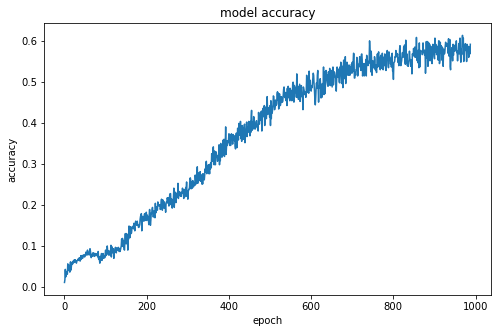

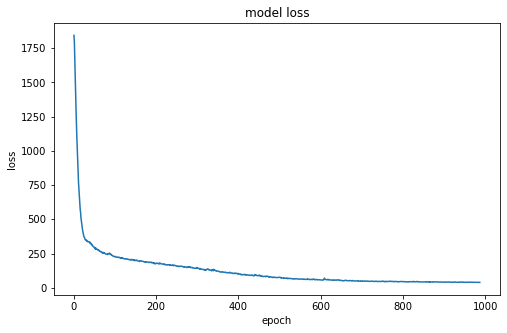

In [60]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,5)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()